In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv("Uber Request Data.csv")
df.head(5)

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp
0,619,Airport,1.0,Trip Completed,11/7/2016 11:51,11/7/2016 13:00
1,867,Airport,1.0,Trip Completed,11/7/2016 17:57,11/7/2016 18:47
2,1807,City,1.0,Trip Completed,12/7/2016 9:17,12/7/2016 9:58
3,2532,Airport,1.0,Trip Completed,12/7/2016 21:08,12/7/2016 22:03
4,3112,City,1.0,Trip Completed,13-07-2016 08:33:16,13-07-2016 09:25:47


In [3]:
df.dtypes

Request id             int64
Pickup point          object
Driver id            float64
Status                object
Request timestamp     object
Drop timestamp        object
dtype: object

In [4]:
df["Request timestamp"] = pd.to_datetime(df["Request timestamp"])
df["Drop timestamp"] = pd.to_datetime(df["Drop timestamp"])

In [5]:
df.columns = [col.replace(' ', '_') for col in df.columns]
df=df.drop(['Request_id','Driver_id','Drop_timestamp'], axis=1)
df.head()

,Pickup_point,Status,Request_timestamp
0,Airport,Trip Completed,2016-11-07 11:51:00
1,Airport,Trip Completed,2016-11-07 17:57:00
2,City,Trip Completed,2016-12-07 09:17:00
3,Airport,Trip Completed,2016-12-07 21:08:00
4,City,Trip Completed,2016-07-13 08:33:16


In [6]:
df['Status'].unique()

array(['Trip Completed', 'Cancelled', 'No Cars Available'], dtype=object)

### Session Details
    Late Night: Midnight to 4AM
    Early Morning: 4AM-8AM
    Late Morning: 8AM-Noon
    Afternoon: Noon-4PM
    Evening: 4PM-8PM
    Night: 8PM-Midnight

In [7]:
Session_lebels = ['Late Night','Morining','Late Morning','Sfternoon','Evining','Night']
df = df.assign(session = pd.cut(df.Request_timestamp.dt.hour,[-1,4,8,12,16,20,24],labels=Session_lebels))
df.head()

,Pickup_point,Status,Request_timestamp,session
0,Airport,Trip Completed,2016-11-07 11:51:00,Late Morning
1,Airport,Trip Completed,2016-11-07 17:57:00,Evining
2,City,Trip Completed,2016-12-07 09:17:00,Late Morning
3,Airport,Trip Completed,2016-12-07 21:08:00,Night
4,City,Trip Completed,2016-07-13 08:33:16,Morining


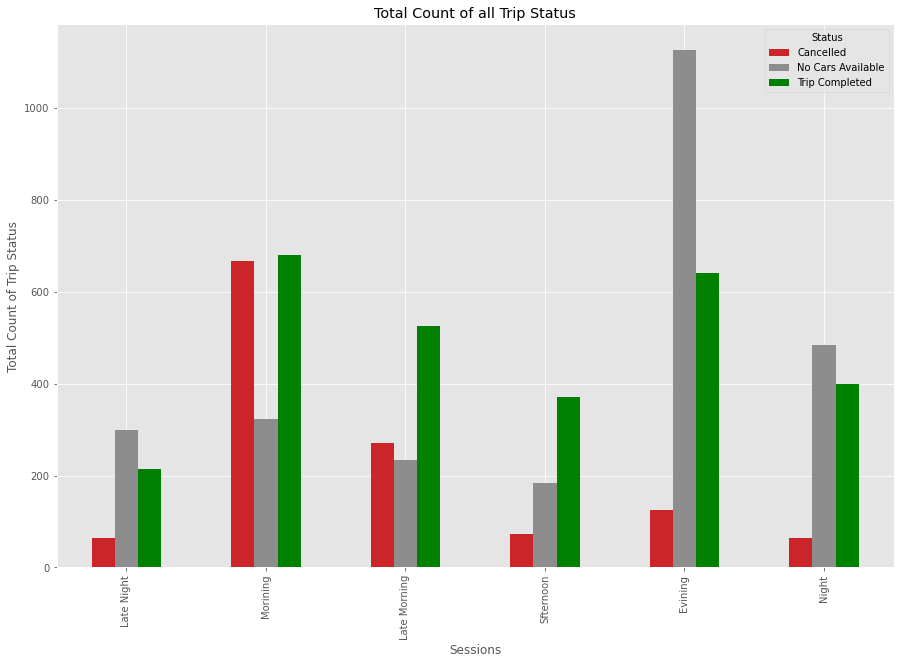

In [8]:
# plotting share/frequency of all "Trip Status" over the day to identify problem areas
plt.style.use('ggplot')
colors = ["#CC2529", "#8E8D8D","#008000"]
df.groupby(['session','Status']).Status.count().unstack().plot.bar(legend=True, figsize=(15,10), color=colors)
plt.title('Total Count of all Trip Status')
plt.xlabel('Sessions')
plt.ylabel('Total Count of Trip Status')
plt.show()

## Observations:

#### 1. Maximum number of "No Cars Available" status trips can be seen in Evening Session (Time Slot: 4PM                           to 8PM), followed by Night session (8PM to Midnight).
#### 2. Maximum number of "Cancelled" status trips can be seen in Early Morning Session (Time Slot: 4AM                             to 8AM), followed by Late Morning session (8AM to Noon).
#### 3. Let's drill down further in each category to do a deeper analysis

In [9]:
# Filtering out only "Cancelled"  trips
df_tripscancelled=df[df["Status"].str.contains('Cancelled')==True]
df_tripscancelled=df_tripscancelled.reset_index(drop=True)
df_tripscancelled.head()

,Pickup_point,Status,Request_timestamp,session
0,City,Cancelled,2016-07-13 06:08:41,Morining
1,City,Cancelled,2016-07-14 17:07:58,Evining
2,Airport,Cancelled,2016-07-14 20:51:37,Evining
3,City,Cancelled,2016-07-15 10:12:40,Late Morning
4,Airport,Cancelled,2016-12-07 19:14:00,Evining


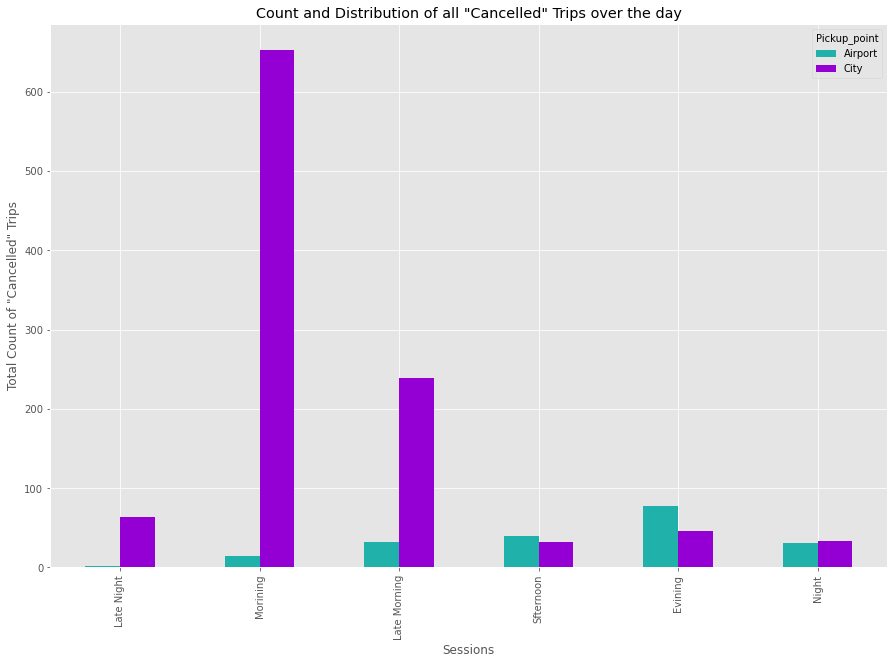

In [10]:
# plotting share/frequency of all Cancelled trips over the day to identify problem areas
plt.style.use('ggplot')
colors = ["#20B2AA", "#9400D3"]
df_tripscancelled.groupby(['session','Pickup_point']).Pickup_point.count().unstack().plot.bar(legend=True, figsize=(15,10), color=colors)
plt.title('Count and Distribution of all "Cancelled" Trips over the day')
plt.xlabel('Sessions')
plt.ylabel('Total Count of "Cancelled" Trips')
plt.show()

##### Observation¶
###### Maximum Cancellations happen in "Early Morning" (4AM-8AM) session where the pick up is "City", followed by Late Morning session (8AM-Noon)
##### Inference:
###### Most number of cancellations happen in the Morning hours (4AM-8AM) in the City to Airport route

In [11]:
# Filtering out only "Cancelled"  trips
df_nocar=df[df["Status"].str.contains('No Car')==True]
df_nocar=df_nocar.reset_index(drop=True)
df_nocar.head()

,Pickup_point,Status,Request_timestamp,session
0,City,No Cars Available,2016-11-07 00:02:00,Late Night
1,City,No Cars Available,2016-11-07 00:06:00,Late Night
2,City,No Cars Available,2016-11-07 00:09:00,Late Night
3,Airport,No Cars Available,2016-11-07 00:23:00,Late Night
4,Airport,No Cars Available,2016-11-07 00:30:00,Late Night


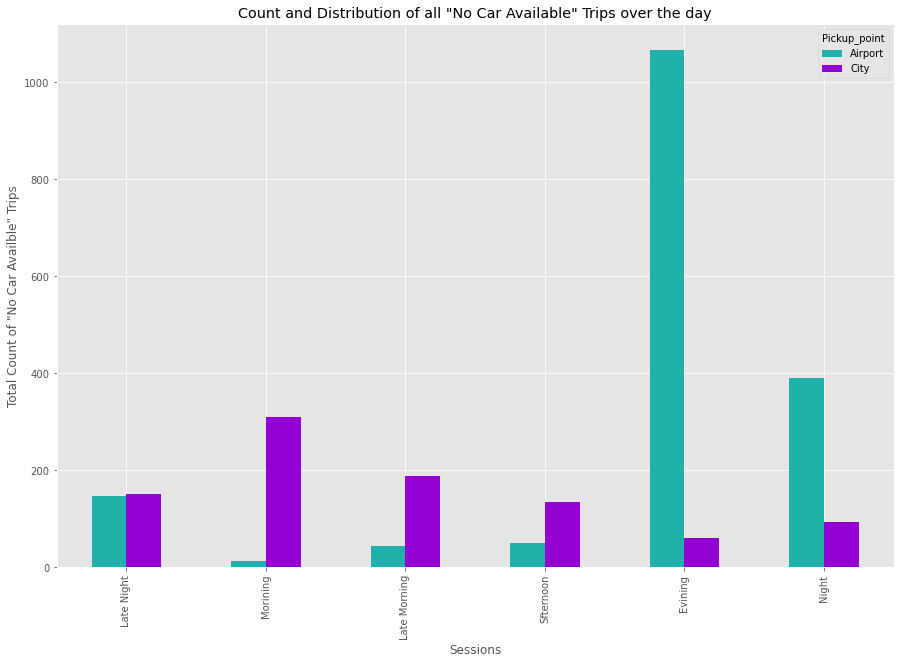

In [12]:
plt.style.use('ggplot')
colors = ["#20B2AA", "#9400D3"]
df_nocar.groupby(['session','Pickup_point']).Pickup_point.count().unstack().plot.bar(legend=True, figsize=(15,10), color=colors)
plt.title('Count and Distribution of all "No Car Available" Trips over the day')
plt.xlabel('Sessions')
plt.ylabel('Total Count of "No Car Availble" Trips')
plt.show()

## Observation :
##### 1. Maximum "No Cars Available" trips happen in "Evening" (4PM-8PM) session where the pick up is "Airport", followed by Night session (8PM-Midnight)
## Inference
#### 2.Most number of No Cars Available happen in the Evening Hours (4PM-8PM) in the Airport to City route

## Let's drill down further by Pick-Up Point

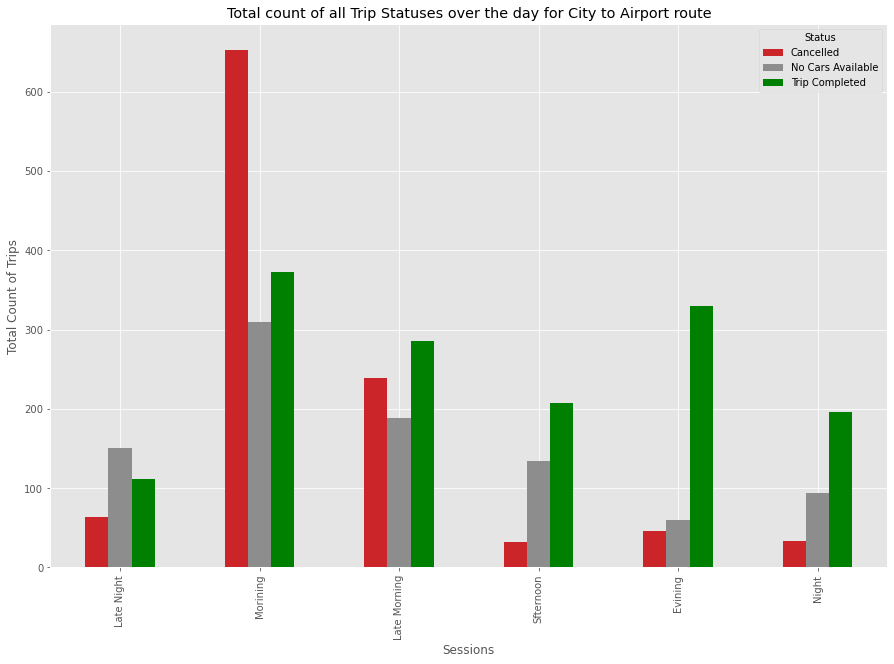

In [13]:
# Filtering out trips in the City to Airport route. Pick-up Point - City
df_citytoairport=df[df["Pickup_point"].str.contains('City')==True]
plt.style.use('ggplot')
colors = ["#CC2529", "#8E8D8D","#008000"]
df_citytoairport.groupby(['session','Status']).Status.count().unstack().plot.bar(legend=True, figsize=(15,10), color=colors)
plt.title('Total count of all Trip Statuses over the day for City to Airport route')
plt.xlabel('Sessions')
plt.ylabel('Total Count of Trips')
plt.show()

###### We see that maximum trips are cancelled from City to airport in the Early Morning session followed by Late Morning Session.

In [14]:
df["Supply_demand"] = ["supply" if x == "Trip Completed" else "Demand" for x in df["Status"]]
df.head(5)

,Pickup_point,Status,Request_timestamp,session,Supply_demand
0,Airport,Trip Completed,2016-11-07 11:51:00,Late Morning,supply
1,Airport,Trip Completed,2016-11-07 17:57:00,Evining,supply
2,City,Trip Completed,2016-12-07 09:17:00,Late Morning,supply
3,Airport,Trip Completed,2016-12-07 21:08:00,Night,supply
4,City,Trip Completed,2016-07-13 08:33:16,Morining,supply


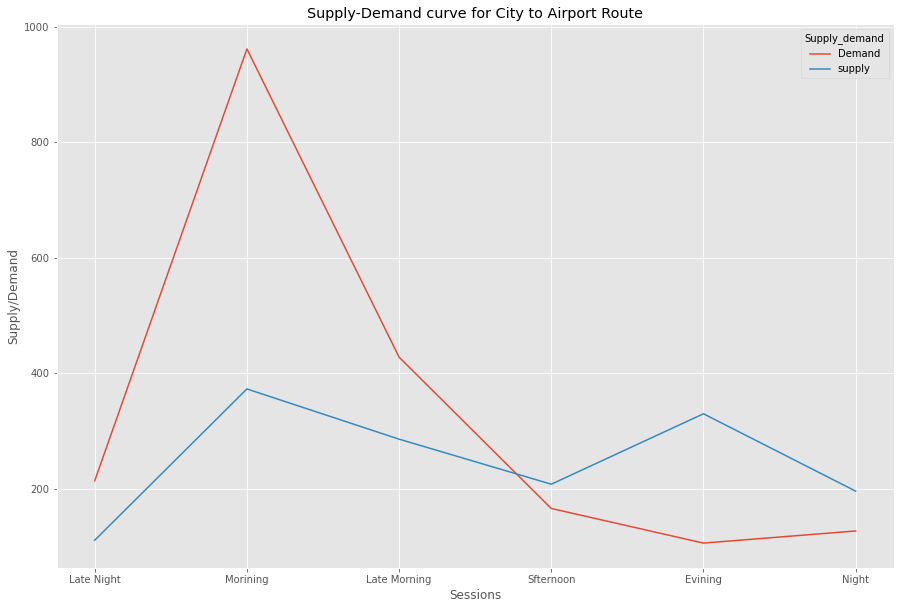

In [15]:
#Plotting Supply and Demand on the City to Airport Route
df_city_to_airport_supply_demand=df[df["Pickup_point"].str.contains('City')==True]
plt.style.use('ggplot')
df_city_to_airport_supply_demand.groupby(['session','Supply_demand']).Supply_demand.count().unstack().plot.line(legend=True, figsize=(15,10))
plt.title('Supply-Demand curve for City to Airport Route')
plt.xlabel('Sessions')
plt.ylabel('Supply/Demand')
plt.show()

##### We observe that the Demand is very high in the morning from City to Airport route but the supply is very low

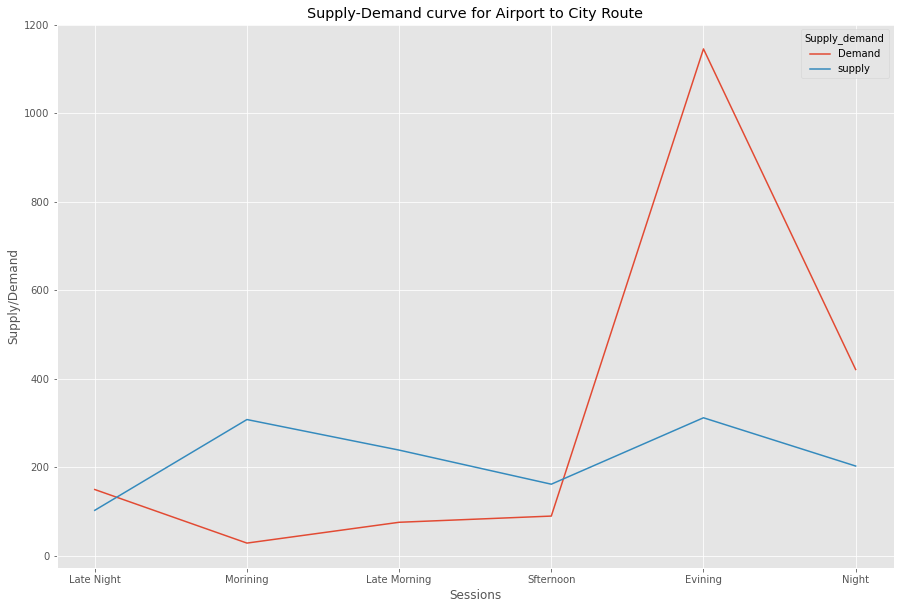

In [16]:
#Plotting Supply and Demand on the Airport to City route
df_airport_to_city_supply_demand=df[df["Pickup_point"].str.contains('Airport')==True]
plt.style.use('ggplot')
df_airport_to_city_supply_demand.groupby(['session','Supply_demand']).Supply_demand.count().unstack().plot.line(legend=True, figsize=(15,10))
plt.title('Supply-Demand curve for Airport to City Route')
plt.xlabel('Sessions')
plt.ylabel('Supply/Demand')
plt.show()

## We observe that the Demand is very high in the evening in the Airport to City route but the supply is very low

### Correlating these two plots, a possible hypothesis could be:
###### The demand during morning and afternoon hours from the Airport to City is quite low, which means that a driver who completed a City to Airport route in the morning hours may have to wait a really long time to get a ride back to the City, or he may have to come back without a passenger. Both situations are not idle for drivers, which might be the reason for highest number of "Cancelled" trips in the City to Airport trip in the morning hours

###### The vice versa happens in evening when there are too many flight coming in to the airport and hence there is a high demand for cabs and not enough supply. which is why most number of "No Cars Available" were observed in Evening in the Airport to City route.

## Possible Solution:
###### 1.Give incentives/surge pricing/bonus for trips from City to Airport during Morning hours.
###### 2.Give incentives/surge pricing/bonus for trips from Airport to City during Evening hours.
###### 3.Uber can give Gas expense to drivers qwhen they return from Airport without a ride or go to airpot for pick up without a ride.
###### 4.Give incentives/surge pricing/bonus for trips from City to Airport during Morning hours.
###### 5.Give incentives/surge pricing/bonus for trips from Airport to City during Evening hours.
###### 6Uber can give Gas expense to drivers qwhen they return from Airport without a ride or go to airpot for pick up without a ride.
###### 7.Uber can increase market share by marketing campaigns and offers to customers when demand is low.